In [3]:
from google.colab import files
uploaded = files.upload()


Saving content.jpg to content.jpg
Saving style.jpg to style.jpg


In [0]:
import cv2
import numpy as np
from keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.preprocessing.image import load_img, img_to_array
from keras.models import  Model
from keras.layers import Input
import keras.backend as K


In [0]:
# ====== Load pretrained keras model for VGG19=========
model = vgg19.VGG19(include_top = True)
model.trainable = False

In [0]:
# ======= Preprocessing Input images ===================
content_img = load_img('content.jpg',target_size = (500,500))
content_img_arr = img_to_array(content_img)
content_img_arr = K.variable(preprocess_input(np.expand_dims(content_img_arr, axis = 0)),dtype = 'float32')

style_img = load_img('style.jpg',target_size = (500,500))
style_img_arr = img_to_array(style_img)
style_img_arr = K.variable(preprocess_input(np.expand_dims(style_img_arr, axis = 0)),dtype = 'float32')

generated_img = np.random.randint(256, size = (500,500,3)).astype('float64')
generated_img = preprocess_input(np.expand_dims(generated_img, axis=0))

generated_img_ph = K.placeholder(shape=(1,500,500,3))

In [0]:
#======== style features from different layers =====================
def get_features(img, layer_names, model):
  features = []
  for layer in layer_names:
    feature = model.get_layer(layer).output
    feature_shape = K.shape(feature).eval(session= tf_session)
    M = feature_shape[1]*feature_shape[2]
    N = feature_shape[3]
    feature = K.reshape(feature, (M,N))
    feature = K.transpose(feature)
    features.append(feature)
  return features  

In [0]:
#============= Content Loss ===========================
def content_loss(F, P):   # F and P are feature representation of content and generated image
  loss = 0.5*K.sum(K.square(F-P))
  return loss

In [0]:
# ========== Gram Matrix ===========================
def Gram_matrix(f):
  G = K.dot(f, K.transpose(f))
  return G

In [0]:
# ============ Style loss =============================
def style_loss(Ws, As, Gs):
  net_loss = K.variable(0.0)
  for w,A,G in zip(Ws,As,Gs):
    const = 4*(K.int_shape(A)[0]**2)*(K.int_shape(A)[1]**2)
    A_gram = Gram_matrix(A)
    G_gram = Gram_matrix(G)
    net_loss += (w*K.sum(np.square(G-A)))/const  # w=1/5 because there are 5 layers for style loss calculation
  return net_loss  

In [0]:
style_loss(style_img, generated_img)

In [0]:
# ============= Total loss function =======================
def total_loss(generated_img_ph, alpha = 1, beta = 1000.0):
  F = get_features(generated_img_ph, layer_names=[content_layer_names], model= g_model)[0]
  Gs = get_features(generated_img_ph, layer_names=style_layer_names, model = g_model)
  s_loss = style_loss(Ws, As, Gs)
  c_loss = content_loss(F, P)
  net_loss = (alpha*c_loss) + (beta*s_loss)
  return net_loss

In [0]:
#=============== loss function =============================
def loss_function(g_img_arr):
  if g_img_arr.shape != (1, 500,500, 3):
    g_img_arr = g_img_arr.reshape((1,500,500, 3))
  func = K.function([g_model.input], [total_loss(g_model.input)])
  return func([g_img_arr])[0].astype('float64')

In [0]:
tf_session = K.get_session()
c_model = vgg19.VGG19(include_top = False, input_tensor=content_img_arr)
s_model = vgg19.VGG19(include_top = False, input_tensor=style_img_arr)
g_model = vgg19.VGG19(include_top = False, input_tensor= generated_img_ph)

In [0]:
content_layer_names ='block4_conv2'
style_layer_names = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

In [0]:
P = get_features(content_img_arr,[content_layer_names],c_model)
As = get_features(style_img_arr,style_layer_names,s_model)
Ws = np.ones(len(style_layer_names))/float(len(style_layer_names))

In [0]:
def get_grad(g_img_arr):
  
  """
  Calculate the gradient of the loss function with respect to the generated image
  """
  if g_img_arr.shape != (1, 500, 500, 3):
      g_img_arr = g_img_arr.reshape((1, 500,500, 3))
  grad_fcn = K.function([g_model.input], 
                        K.gradients(total_loss(g_model.input), [g_model.input]))
  grad = grad_fcn([g_img_arr])[0].flatten().astype('float64')
  return grad

In [0]:
from scipy.optimize import fmin_l_bfgs_b

In [0]:
iterations = 10
x_val = generated_img.flatten()
xopt, f_val, info= fmin_l_bfgs_b(loss_function, x_val, fprime=get_grad,maxiter=iterations, disp=True)

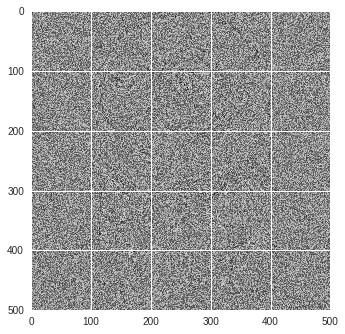

In [80]:
plt.imshow(np.reshape(xopt,(500,500,3))[:,:,0])